In [71]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot


from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet

import optuna

import warnings
pd.set_option('display.max_columns', None)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter('ignore', pd.errors.SettingWithCopyWarning)
warnings.simplefilter(action="ignore", category=pd.errors.PerformanceWarning)


In [72]:
train_wOrdinal = pd.read_csv('~/Documents/AmesHousingML/data_cleaning/data_ordinal.csv') 
train_originalCleaned = pd.read_csv('~/Documents/AmesHousingML/data_cleaning/data_original.csv') 
train_wOnlyDummies = pd.read_csv('~/Documents/AmesHousingML/data_cleaning/data_dummies.csv') 
train_wOnlyDummiesNoDrop = pd.read_csv('~/Documents/AmesHousingML/data_cleaning/data_dummies_noDrop.csv') 

In [73]:
# Create a KFold object
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [74]:
masterScores = pd.DataFrame(columns = ['Model', 'data_process', 'r2_5kf_mean', 'rmse_5kf_mean'])

In [75]:
ourFrames = [train_wOrdinal, train_wOnlyDummies, train_wOnlyDummiesNoDrop]
outlierType = ['threeXOutlier', 'onlyNormalCondition', 'allOutliers']

In [76]:
for dataframe in ourFrames:
    dataset = 'NaN'
    if (dataframe.equals(train_wOrdinal)):
        dataset = 'ordinal'
    elif (dataframe.equals(train_wOnlyDummies)):
        dataset = 'dummified'
    elif (dataframe.equals(train_wOnlyDummiesNoDrop)):
        dataset = 'dummifiedNoDrop'
        
    for trial in outlierType:
        #this will create the model name by which outlier type, below we will adjust the dataset
        # to match the outlier type being tested, it will then be stored by dataset_outlierType
        model_name = 'randomForest'
        data_process = f"{dataset}_{trial}"
        
        #below is filtering out the 3*IQR range if the trial is for that purpose
        if (trial == 'threeXOutlier'):
            frame = dataframe.copy()
            outlier_threshold = 3
            Q1 = frame['SalePrice'].quantile(.25)
            Q3 = frame['SalePrice'].quantile(.75)
            IQR = Q3 - Q1
            new_bounds = Q3 + outlier_threshold * IQR
            frame.drop(frame[frame['SalePrice'] > new_bounds].index, axis=0, inplace = True)
            
        #below is filtering out the houses that sold in normal condition
        elif (trial == 'onlyNormalCondition'):
            frame = dataframe.copy()
            if (frame.equals(train_wOrdinal)):
                frame = frame[frame['SaleCondition'] == 4]
            elif (frame.equals(train_wOnlyDummies)):
                frame = frame[frame['SaleCondition_Normal'] == 1.0]
            elif (frame.equals(train_wOnlyDummiesNoDrop)):
                frame = frame[frame['SaleCondition_Normal'] == 1.0]
                
        elif (trial == 'allOutliers'):
            frame = dataframe.copy()
        
    
        #the features will be X (independent variables)
        X = frame.drop('SalePrice', axis=1)
        X_array = X.values
        #the target (dependent variable) will be y
        y = frame['SalePrice']
        y_array = y.values

        #Split your training and testing sets of data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        rf_model = RandomForestRegressor(n_estimators=100, random_state=42) 


        # Train the model on the training set
        rf_model.fit(X_train, y_train)

        # Make predictions on the test set
        rf_model_y_pred = rf_model.predict(X_test)

       
        # Display feature importances
        feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': rf_model.feature_importances_})
        feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
        print('\nFeature Importances:')
        print(feature_importances)
        
        # Perform cross-validation
        cv_scores = cross_val_score(rf_model, X, y, cv=kf, scoring='r2')
        
        def rmse_scorer(y_true, y_pred):
            mse = mean_squared_error(y_true, y_pred)
            rmse = np.sqrt(mse)
            return rmse
    
        # Define the scoring function using neg_mean_squared_error
        scorer = make_scorer(rmse_scorer)
        
        # Use cross_val_score with the defined scorer
        rmse_scores = cross_val_score(rf_model, X, y, cv=kf, scoring=scorer)
        
        # Display the cross-validation scores
        print("Cross-Validation Scores:", cv_scores, '\n')
        print(f"Mean R^2: {cv_scores.mean()}", '\n') 
        
      
        record = {'Model': model_name, 'data_process': data_process, 'r2_5kf_mean': cv_scores.mean(), 'rmse_5kf_mean': rmse_scores.mean()}
        masterScores = masterScores.append(record, ignore_index=True)

        print('\n')
        print('\n')
        print('\n')


Feature Importances:
            Feature  Importance
80    HighQualFinSF    0.284207
75     TotalHouseSF    0.234177
17      OverallQual    0.228633
19        YearBuilt    0.048281
78  YearAndRemodAvg    0.014030
..              ...         ...
39          Heating    0.000081
14       Condition2    0.000055
45     LowQualFinSF    0.000010
9         Utilities    0.000002
5            Street    0.000001

[84 rows x 2 columns]
Cross-Validation Scores: [0.90534655 0.89726329 0.92180905 0.90527193 0.87188329] 

Mean R^2: 0.9003148232051504 








Feature Importances:
            Feature  Importance
80    HighQualFinSF    0.316815
17      OverallQual    0.278752
75     TotalHouseSF    0.196350
78  YearAndRemodAvg    0.028695
19        YearBuilt    0.013944
..              ...         ...
5            Street    0.000008
45     LowQualFinSF    0.000008
14       Condition2    0.000001
9         Utilities    0.000000
74    SaleCondition    0.000000

[84 rows x 2 columns]
Cross-Validation Scor

In [77]:
for dataframe in ourFrames:
    dataset = 'NaN'
    if (dataframe.equals(train_wOrdinal)):
        dataset = 'ordinal'
    elif (dataframe.equals(train_wOnlyDummies)):
        dataset = 'dummified'
    elif (dataframe.equals(train_wOnlyDummiesNoDrop)):
        dataset = 'dummifiedNoDrop'
        
    for trial in outlierType:
        #this will create the model name by which outlier type, below we will adjust the dataset
        # to match the outlier type being tested, it will then be stored by dataset_outlierType
        model_name = 'randomForest_tuned'
        data_process = f"{dataset}_{trial}"
        
        #below is filtering out the 3*IQR range if the trial is for that purpose
        if (trial == 'threeXOutlier'):
            frame = dataframe.copy()
            outlier_threshold = 3
            Q1 = frame['SalePrice'].quantile(.25)
            Q3 = frame['SalePrice'].quantile(.75)
            IQR = Q3 - Q1
            new_bounds = Q3 + outlier_threshold * IQR
            frame.drop(frame[frame['SalePrice'] > new_bounds].index, axis=0, inplace = True)
            
        #below is filtering out the houses that sold in normal condition
        elif (trial == 'onlyNormalCondition'):
            frame = dataframe.copy()
            if (frame.equals(train_wOrdinal)):
                frame = frame[frame['SaleCondition'] == 4]
            elif (frame.equals(train_wOnlyDummies)):
                frame = frame[frame['SaleCondition_Normal'] == 1.0]
            elif (frame.equals(train_wOnlyDummiesNoDrop)):
                frame = frame[frame['SaleCondition_Normal'] == 1.0]
                
        elif (trial == 'allOutliers'):
            frame = dataframe.copy()
        
    
        #the features will be X (independent variables)
        X = frame.drop('SalePrice', axis=1)
        X_array = X.values
        #the target (dependent variable) will be y
        y = frame['SalePrice']
        y_array = y.values

        #Split your training and testing sets of data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        params = {'max_depth': 15, 'min_samples_split': 3, 'n_estimators': 500, 'random_state': 42}
        
        rf_model = RandomForestRegressor(**params) 


        # Train the model on the training set
        rf_model.fit(X_train, y_train)

        # Make predictions on the test set
        rf_model_y_pred = rf_model.predict(X_test)

       
        # Display feature importances
        feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': rf_model.feature_importances_})
        feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
        print('\nFeature Importances:')
        print(feature_importances)
        
        # Perform cross-validation
        cv_scores = cross_val_score(rf_model, X, y, cv=kf, scoring='r2')
        
        def rmse_scorer(y_true, y_pred):
            mse = mean_squared_error(y_true, y_pred)
            rmse = np.sqrt(mse)
            return rmse
    
        # Define the scoring function using neg_mean_squared_error
        scorer = make_scorer(rmse_scorer)
        
        # Use cross_val_score with the defined scorer
        rmse_scores = cross_val_score(rf_model, X, y, cv=kf, scoring=scorer)
        
        # Display the cross-validation scores
        print("Cross-Validation Scores:", cv_scores, '\n')
        print(f"Mean R^2: {cv_scores.mean()}", '\n') 
        
      
        record = {'Model': model_name, 'data_process': data_process, 'r2_5kf_mean': cv_scores.mean(), 'rmse_5kf_mean': rmse_scores.mean()}
        masterScores = masterScores.append(record, ignore_index=True)

        print('\n')
        print('\n')
        print('\n')


Feature Importances:
            Feature  Importance
80    HighQualFinSF    0.286975
17      OverallQual    0.236629
75     TotalHouseSF    0.224243
19        YearBuilt    0.046225
78  YearAndRemodAvg    0.015076
..              ...         ...
14       Condition2    0.000069
39          Heating    0.000057
45     LowQualFinSF    0.000012
9         Utilities    0.000004
5            Street    0.000003

[84 rows x 2 columns]
Cross-Validation Scores: [0.90742674 0.8993971  0.92142462 0.90552341 0.87493594] 

Mean R^2: 0.9017415635666446 








Feature Importances:
            Feature    Importance
80    HighQualFinSF  3.302458e-01
17      OverallQual  2.611189e-01
75     TotalHouseSF  2.044460e-01
78  YearAndRemodAvg  2.847192e-02
19        YearBuilt  1.406462e-02
..              ...           ...
45     LowQualFinSF  2.206404e-05
39          Heating  1.383280e-05
5            Street  2.629301e-06
9         Utilities  2.655846e-08
74    SaleCondition  0.000000e+00

[84 rows x 2 column

In [78]:
# {'max_depth': 15, 'min_samples_split': 3, 'n_estimators': 500}
train_wOrdinal.head()

,GrLivArea,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,Fence,MoSold,YrSold,SaleType,SaleCondition,TotalHouseSF,TotalBathroomCount,QualityOutdoorSF,YearAndRemodAvg,NonHouseSF,HighQualFinSF,HouseLotRatio,FrontageLotRatio,QualityOutdoorLotRatio
0,856,126000,30,5,60.0,7890,1,1,3,3,0,0,0,19,2,2,0,2,6,6,1939,1950,1,0,13,14,2,0.0,3,3,1,4,4,2,3,238.0,1,0.0,618.0,856.0,1,3,1,3,856,0,0,1.0,0.0,1,0,2,1,3,4,6,1,5,5,1939.0,1,2.0,399.0,4,4,2,0,0,0,0,166,1,3,2010,9,4,1712.0,2.0,166,1944.5,6178.0,1712.0,21.698352,0.760456,2.103929
1,1049,139500,120,5,42.0,4235,1,1,3,3,0,4,0,7,2,2,4,2,5,5,1984,1984,1,0,6,6,1,149.0,4,3,1,5,4,3,3,552.0,2,393.0,104.0,1049.0,1,3,1,3,1049,0,0,1.0,0.0,2,0,2,1,4,5,6,0,1,1,1984.0,3,1.0,266.0,4,4,2,0,105,0,0,0,1,2,2009,9,4,2098.0,3.0,105,1984.0,2137.0,2098.0,49.539551,0.991736,2.479339
2,1001,124900,30,1,60.0,6060,1,1,3,3,0,4,0,10,2,2,0,2,5,9,1930,2007,3,0,8,8,2,0.0,4,3,0,4,4,2,2,737.0,1,0.0,100.0,837.0,1,5,1,3,1001,0,0,0.0,0.0,1,0,2,1,4,5,6,0,1,5,1930.0,1,1.0,216.0,4,2,0,154,0,42,86,0,1,11,2007,9,4,1838.0,1.0,282,1968.5,4222.0,1838.0,30.330033,0.990099,4.653465
3,1039,114000,70,5,80.0,8146,1,1,3,3,0,0,0,18,2,2,0,5,4,8,1900,2003,1,0,8,8,2,0.0,4,4,0,3,4,2,1,0.0,1,0.0,405.0,405.0,1,4,1,3,717,322,0,0.0,0.0,1,0,2,1,3,6,6,0,1,5,1940.0,1,1.0,281.0,4,4,0,0,0,168,0,111,1,5,2009,9,4,1444.0,1.0,279,1951.5,6702.0,1444.0,17.726492,0.982077,3.424994
4,1665,227000,60,5,70.0,8400,1,1,3,3,0,4,0,15,2,2,0,5,8,6,2001,2001,1,0,12,13,2,0.0,4,3,2,5,4,2,3,643.0,1,0.0,167.0,810.0,1,5,1,3,810,855,0,1.0,0.0,2,1,3,1,4,6,6,0,1,1,2001.0,3,2.0,528.0,4,4,2,0,45,0,0,0,1,11,2009,9,4,2475.0,3.5,45,2001.0,5925.0,2475.0,29.464286,0.833333,0.535714


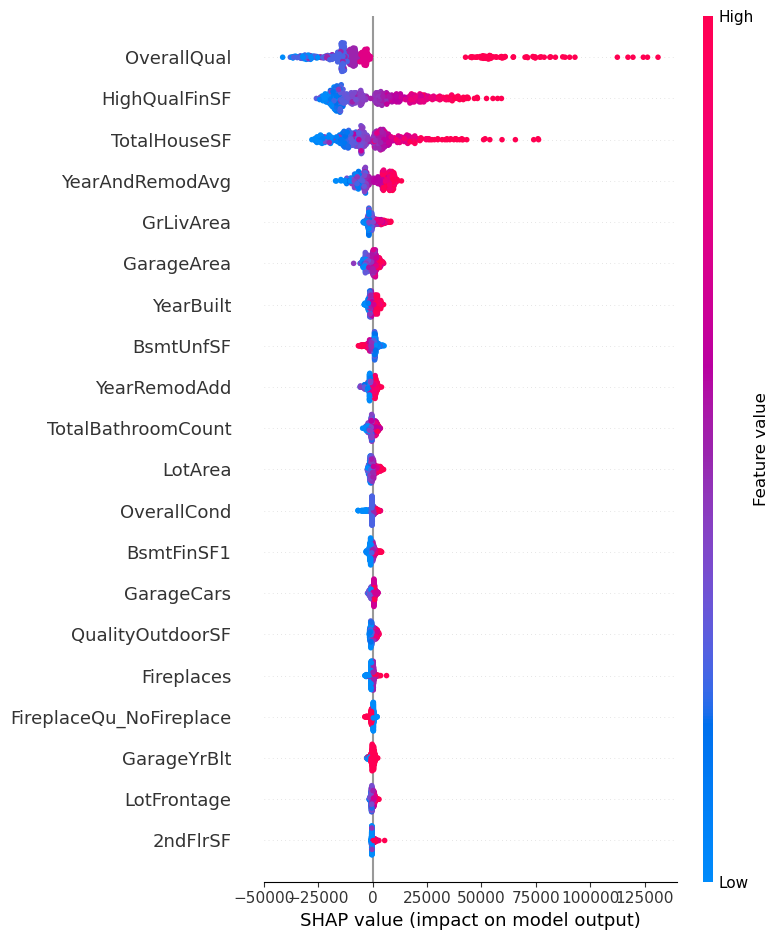

In [79]:
import shap

# Use the SHAP explainer
explainer = shap.Explainer(rf_model)

# Calculate SHAP values for a subset of the data (e.g., test set)
shap_values = explainer.shap_values(X_test)

# Plot summary plot
shap.summary_plot(shap_values, X_test)

In [80]:
masterScores

,Model,data_process,r2_5kf_mean,rmse_5kf_mean
0,randomForest,ordinal_threeXOutlier,0.900315,21063.431020
1,randomForest,ordinal_onlyNormalCondition,0.914710,20557.040480
2,randomForest,ordinal_allOutliers,0.900703,23595.621432
3,randomForest,dummified_threeXOutlier,0.897686,21340.686856
4,randomForest,dummified_onlyNormalCondition,0.913220,20743.874589
5,randomForest,dummified_allOutliers,0.898702,23829.250646
6,randomForest,dummifiedNoDrop_threeXOutlier,0.898322,21273.463159
7,randomForest,dummifiedNoDrop_onlyNormalCondition,0.914006,20643.846124
8,randomForest,dummifiedNoDrop_allOutliers,0.898781,23817.907706
9,randomForest_tuned,ordinal_threeXOutlier,0.901742,20919.551383


In [81]:
output_file = 'masterScores_randomForest.csv'

masterScores.to_csv(output_file, index=False, mode='w')

print(f"DataFrame exported to '{output_file}' in the same working directory.")

DataFrame exported to 'masterScores_randomForest.csv' in the same working directory.


In [82]:
# def objective(trial):
#     params = {
#         'n_estimators': trial.suggest_int('n_estimators', 50, 500),
#         'max_depth': trial.suggest_int('max_depth', 4, 20),
#         'min_samples_split': trial.suggest_float('min_samples_split', 0.1, 1.0),
#         'min_samples_leaf': trial.suggest_float('min_samples_leaf', 0.1, 0.5),
#     }

#     model = RandomForestRegressor(**params, random_state=42)
#     model.fit(X_train, y_train)

#     predictions = model.predict(X_test)
#     mse = mean_squared_error(y_test, predictions)
#     return mse

# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=100)

# best_params = study.best_params
# best_model = RandomForestRegressor(**best_params, random_state=42)
# best_model.fit(X_train, y_train)

In [83]:
# # Print the best hyperparameters and corresponding RMSE
# print('Best trial:')
# best_trial = study.best_trial
# print(f'Value (negative RMSE): {best_trial.value}')
# print(f'Params: {best_trial.params}')

# # Use the best hyperparameters to train the final model
# best_params = best_trial.params

# final_model = RandomForestRegressor(
#     n_estimators=best_params['n_estimators'],
#     max_depth=best_params['max_depth'],
#     min_samples_split=best_params['min_samples_split'],
#     min_samples_leaf=best_params['min_samples_leaf'],
#     random_state=42
# )

# final_model.fit(X_train, y_train)

# # Make predictions on the test set
# y_pred = final_model.predict(X_test)

# # Calculate R2 on the test set
# r2_test = r2_score(y_test, y_pred)
# print(f"R2 on the test set: {r2_test}")

# # Calculate RMSE on the test set
# rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
# print(f"Root Mean Squared Error (RMSE) on the test set: {rmse_test}")

In [84]:
# y_test

In [85]:
# y_pred

In [86]:
# mean_squared_error(y_test, y_pred, squared = False)

In [87]:
# r2_score(y_test, y_pred)

In [88]:
# best_params['n_estimators']

In [89]:
# #name the model for our score tracker
# model_name = 'randomForest_tuned'

# # Create a Random Forest Regressor
# rft_model = RandomForestRegressor(**rfr_cv.best_params_,
#                                     random_state=42)  # You can adjust n_estimators as needed

# # Train the model on the training set
# rft_model.fit(X_train, y_train)

# # Make predictions on the test set
# rft_y_pred = rft_model.predict(X_test)

# # Evaluate the Random Forest model
# rft_r2 = r2_score(y_test, rft_y_pred)
# # print(f'R-squared on the test set: {rf_r2}')

# rft_mse = mean_squared_error(y_test, rft_y_pred)
# # print(f'Mean Squared Error on the test set: {rf_mse}')

# # Root Mean Squared Error (RMSE) on the test set
# rft_rmse = mean_squared_error(y_test, rft_y_pred, squared=False)
# # print("Root Mean Squared Error (RMSE) on the test set:", rf_rmse)

# # Display feature importances
# feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': rft_model.feature_importances_})
# feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
# print('\nFeature Importances:')
# print(feature_importances)
# # feat_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
# # feat_importances.nlargest(20).plot(kind='barh')

# # Perform cross-validation
# cv_scores = cross_val_score(rft_model, X, y, cv=kf, scoring='r2')
# # You can replace 'r2' with other scoring metrics like 'neg_mean_squared_error', etc.

# def rmse_scorer(y_true, y_pred):
#         mse = mean_squared_error(y_true, y_pred)
#         rmse = np.sqrt(mse)
#         return rmse
    
    
# # Define the scoring function using neg_mean_squared_error
# scorer = make_scorer(rmse_scorer)
# # Use cross_val_score with the defined scorer
# rmse_scores = cross_val_score(rft_model, X, y, cv=kf, scoring=scorer)



# # Display the cross-validation scores
# print("Cross-Validation Scores Rsquared:", cv_scores, '\n')
# print("Cross-Validation Scores RMSE:", rmse_scores, '\n')

# # Print the mean and standard deviation of the scores
# print(f"Mean R^2: {cv_scores.mean()}", '\n')
# print(f"Standard Deviation R^2: {cv_scores.std()}", '\n')
# print(f"Mean RMSE: {rmse_scores.mean()}")

# record = {'Model': model_name, 'r2_5kf_mean': cv_scores.mean(), 'rmse_5kf_mean': rmse_scores.mean()}
# masterScores = masterScores.append(record, ignore_index=True)

In [90]:
# masterScores

In [91]:

# RFR = RandomForestRegressor(random_state=42)

# param_grid_RFR = {
#     'max_depth': [5, 10, 15],
#     'n_estimators': [100, 250, 500],
#     'min_samples_split': [3, 5, 10]
# }

# rfr_cv = GridSearchCV(RFR, param_grid_RFR, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

In [92]:
# rfr_cv.fit(X_train, y_train)

# rfr_cv.best_params_

In [93]:
# rfr_cv.best_params_